# Cluster Analysis

In [326]:
# First we import all neccessary libraries and give some of them an alias for easy access
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib import cm
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

In [327]:
# Read in the data so every group member can run the notebook on his machine
# (our repo is on github, we therefore have the same file structure)
df = pd.read_csv("../../Data/Transformed/Leo/inventory_management_cleaned_transformed.csv")
df.shape # Get a first idea about the number of rows and columns of the dataset

(1722, 10)

In [328]:
# Get a first impression of our data
df.head()

,Category,Region,Inventory Level,Price,Discount,Weather Condition,Promotion,Demand,Product_UID,Weekday
0,1,1,-0.399386,0.084333,-0.601533,1,0,0.038863,S001_P0001,2
1,0,1,-0.737767,0.268861,0.707999,1,1,2.633833,S001_P0002,2
2,0,1,-0.173798,-0.158233,0.053233,1,1,0.994905,S001_P0003,2
3,1,1,-0.642326,0.454134,0.053233,1,0,-1.395199,S001_P0004,2
4,3,1,-0.585929,-0.369795,-1.256300,1,0,-1.235859,S001_P0005,2


In [329]:
# We look at the data to decide how to handle the grouping with categorial data attributes
df[df['Product_UID'] == "S001_P0001"][['Category', 'Region', 'Weather Condition', 'Weekday']]

,Category,Region,Weather Condition,Weekday
0,1,1,1,2
100,1,1,1,3
200,1,1,1,1
300,1,1,1,5
400,1,1,1,6
500,1,1,2,4
600,1,1,1,0
700,1,1,1,2
800,1,1,2,3
900,1,1,0,1


In [330]:
# We group the data by the unique Product_UID, now we are able to look at specific products
# We exclude Weather Condition and Weekday from clustering because they represent external, short-term conditions rather than intrinsic product characteristics
# We exclude promotion as this is our target variable and KMeans is unsupervised
# We take the mean of all numerical attributes and the first value of the non numerical attributes
agg_df = df.groupby('Product_UID').agg({
    'Price': 'mean',
    'Discount': 'mean',
    'Inventory Level': 'mean',
    'Demand': 'mean',
    'Category': 'first',
    'Region': 'first'
}).reset_index()

In [331]:
# Check the aggregated dataframe, we see that we have 100 unique products and their mean characteristics
agg_df

,Product_UID,Price,Discount,Inventory Level,Demand,Category,Region
0,S001_P0001,-0.045300,0.053233,-0.248994,-0.224174,1,1
1,S001_P0002,0.089831,0.162361,-0.508564,1.214946,0,1
2,S001_P0003,-0.279075,0.053233,0.400775,0.562410,0,1
3,S001_P0004,0.571972,0.198737,-0.510010,-0.823597,1,1
4,S001_P0005,-0.265364,0.235113,1.524615,0.250053,3,1
...,...,...,...,...,...,...,...
95,S005_P0016,-0.866584,-0.139345,0.437891,-0.070934,4,1
96,S005_P0017,-0.803455,-0.139345,-0.614000,-0.053527,4,1
97,S005_P0018,-1.164094,0.053233,-0.581336,0.286577,0,1
98,S005_P0019,1.584706,-0.023798,-0.562707,-0.626616,2,1


In [332]:
# We Store the unique identifier column in a variable and then drop it for the analysis as it has no mathematical meaning
product_ids = agg_df['Product_UID']
features = agg_df.drop(columns=['Product_UID'])

In [333]:
# Apply the Principal Component Analysis (PCA) with a fixed number of principal components of 2 in order to be 
# able to visualize our results in two dimensions
pca = PCA(2)
pca_2d = pca.fit_transform(features)
pca_2d = pd.DataFrame(pca_2d, columns=['PC'+str(i) for i in range(1,pca_2d.shape[1]+1)])
pca_2d.head(5)

,PC1,PC2
0,-0.952274,-0.504209
1,-1.829932,-0.804680
2,-1.677200,-0.757337
3,-1.252302,-0.558578
4,0.880483,-0.410108


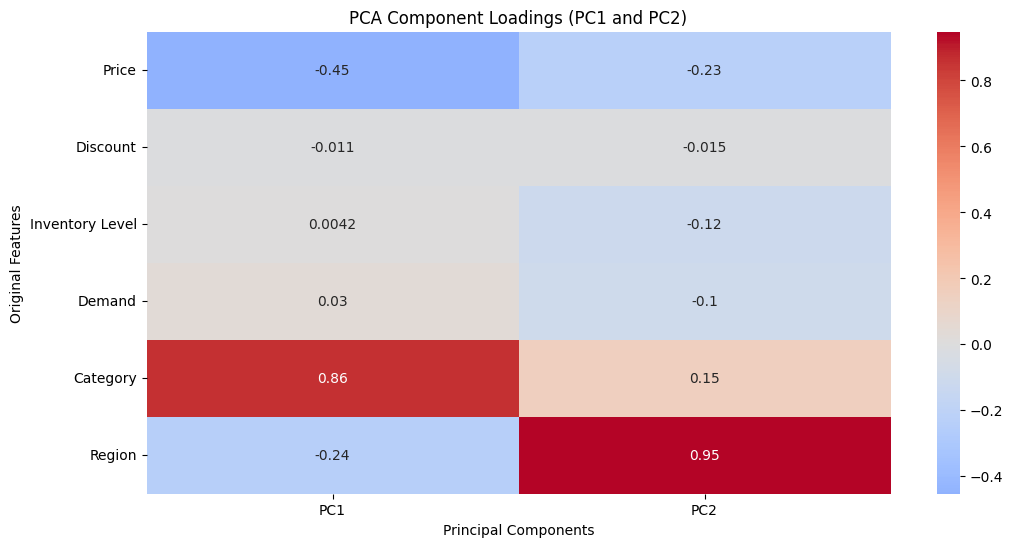

In [334]:
# We want to regain some of the lost explainability by looking out of which attributes the PCAs are composed
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=features.columns)
plt.figure(figsize=(12, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Component Loadings (PC1 and PC2)')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.show()

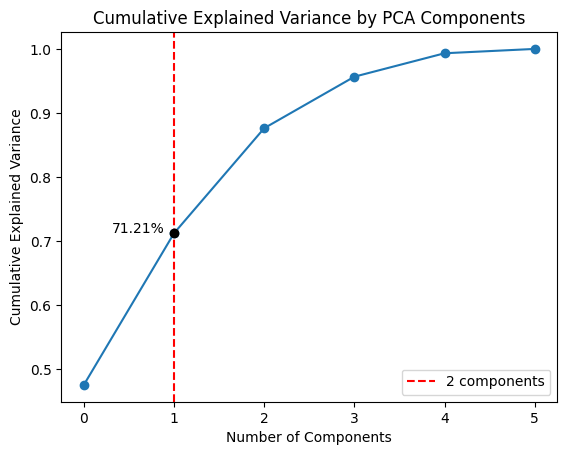

In [335]:
# We conduct a full PCA to get the information how much of the initial dimensions we can explain by using 2 dimensions
pca_full = PCA()
pcadf = pca_full.fit_transform(features)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plotting
#plt.figure(figsize=(18,6))
plt.plot(cumulative_variance, marker='o', linestyle='-')
# We add a vertically dashed line at k=2
plt.axvline(x=1, color='red', linestyle='--', label='2 components')
# We mark the cumulative variance at the 2nd component
y_at_x1 = cumulative_variance[1]
plt.scatter(1, y_at_x1, color='black', zorder=5)
plt.text(0.9, y_at_x1 + 0.0005, f'{y_at_x1:.2%}', ha='right', color='black')


plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.legend()
plt.show()

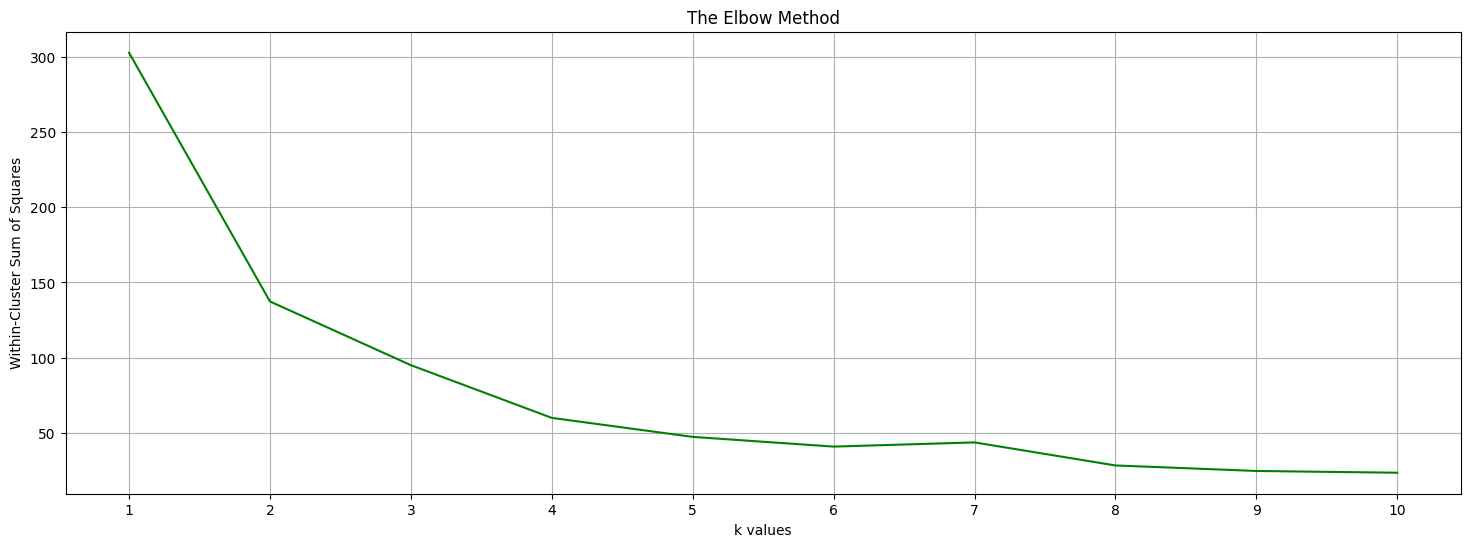

In [336]:
# We get a first hint about the optimal number of clusters with the elbow criterion
inertia_score = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_2d)
    inertia_score.append(kmeans.inertia_)

# We visualize the inertia scores to identify the elbow point
plt.figure(figsize=(18,6))
sns.lineplot(x=range(1,11),y=inertia_score,color='green')
plt.xticks(range(1,11))
plt.xlabel('k values')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('The Elbow Method')
plt.grid()
plt.show()

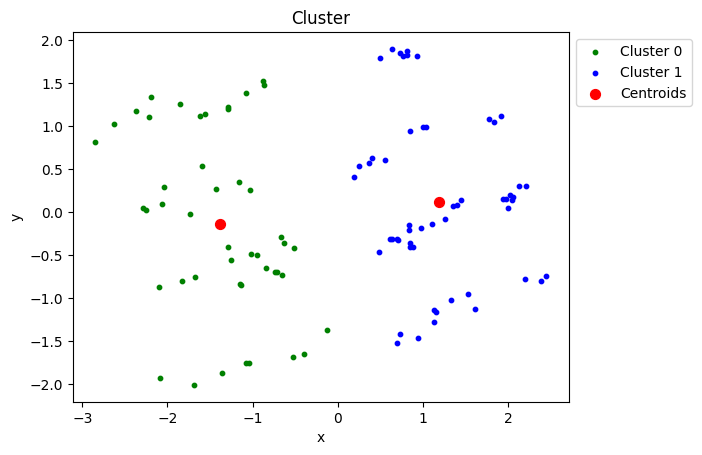

In [337]:
# We visualize the clusters based on the elbow criteria
kmeans = KMeans(n_clusters=2, init="k-means++", n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(pca_2d[["PC1", "PC2"]])
Y_np_2d = pca_2d.to_numpy()
plt.scatter(Y_np_2d[y_kmeans == 0, 0], Y_np_2d[y_kmeans == 0, 1], s = 10, c = 'green', 
            label = 'Cluster 0')
plt.scatter(Y_np_2d[y_kmeans == 1, 0], Y_np_2d[y_kmeans == 1, 1], s = 10, c = 'blue', 
            label = 'Cluster 1')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 50, 
            c = 'red', label = 'Centroids')
plt.title('Cluster')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [338]:
# We create an interactive scatter plot using the Plotly library to zoom in on edge cases between the clusters and get further information
plot_df = pd.DataFrame(pca_2d)
plot_df['Cluster'] = y_kmeans.astype(str)

# Create scatter plot
fig = px.scatter(
    plot_df,
    x='PC1',
    y='PC2',
    color='Cluster',
    title='Interactive 2D KMeans Clustering',
    opacity=0.8,
    color_discrete_sequence=px.colors.qualitative.Set1
)

# Add centroids
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=['PC1', 'PC2'])
centroids_df['Cluster'] = ['Centroid'] * len(centroids)

fig.add_trace(
    go.Scatter(
        x=centroids_df['PC1'],
        y=centroids_df['PC2'],
        mode='markers',
        marker=dict(
            size=15,
            color='black',
            symbol='x',
            line=dict(width=2, color='white')
        ),
        name='Centroids'
    )
)

fig.update_layout(
    xaxis_title='PC1',
    yaxis_title='PC2',
    legend_title_text='Clusters',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

fig.show()

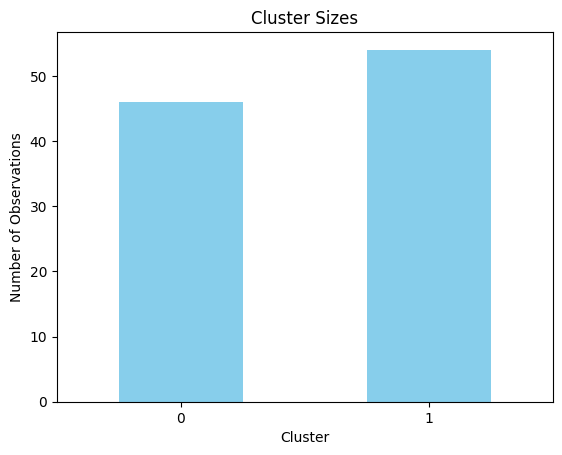

In [339]:
# For further insights we analyze how the observations are distributed in the different clusters
pd.Series(y_kmeans).value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.show()

In [340]:
# We calculate the silhouette score based on the suggestion of the elbow criteria
silhouette_score(pca_2d, y_kmeans)

np.float64(0.48801294948964086)

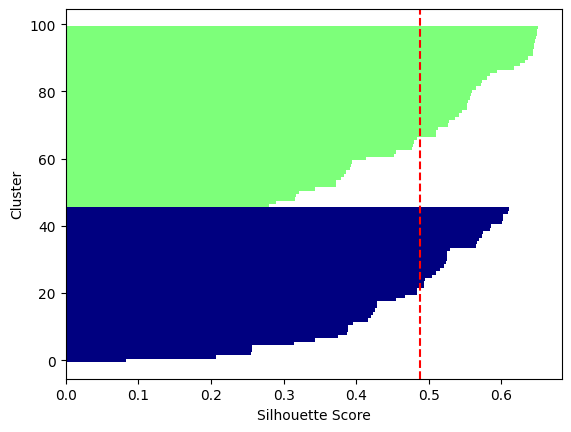

In [341]:
# We visualize the average silhouette scores for k=2
# based on the elbow criteria
cluster_labels = np.unique(y_kmeans)
n_clusters=cluster_labels.shape [0]

silhouette_vals = silhouette_samples(pca_2d, y_kmeans, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_kmeans == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet( i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height = 1.0,
            edgecolor = 'none',
            color = color)
    yticks.append((y_ax_lower + y_ax_upper) / 2 )
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color = 'red', linestyle = "--")
plt.ylabel('Cluster')
plt.xlabel('Silhouette Score')
plt.show()

In [342]:
# We can calculate the silhouette scores of different numbers of clusters to evaluate the optimal number of clusters with a simple for loop
best_k = None
best_score = -1

for k in range(2, 9): 
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    y_kmeans = kmeans.fit_predict(pca_2d)
    score = silhouette_score(pca_2d, y_kmeans)
    print("The silhouette score for k = ",k," is ",score)
    
    if score > best_score:
        best_score = score
        best_k = k

print("Best k:",best_k,"with a silhouette score of ",best_score)

The silhouette score for k =  2  is  0.48801294948964086
The silhouette score for k =  3  is  0.46870987162961547
The silhouette score for k =  4  is  0.4660353535603482
The silhouette score for k =  5  is  0.46610524970460027
The silhouette score for k =  6  is  0.475701520619651
The silhouette score for k =  7  is  0.45547035382007695
The silhouette score for k =  8  is  0.4607387070223158
Best k: 2 with a silhouette score of  0.48801294948964086


In [343]:
# We rerun kmeans with our optimal number of clusters
kmeans = KMeans(n_clusters=2, init="k-means++", n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(pca_2d)

In [344]:
# We add back the unique identifier column
pca_2d["Product_UID"] = product_ids.values

# Store and interpert the Cluster Data

In [345]:
# Read in the data to join the cluster labels with the original dataframe
df_orig = pd.read_csv("../../Data/Transformed/Leo/inventory_management_cleaned.csv")

In [346]:
# Step 1: Prepare cluster labels
# `product_ids` contains Product_UIDs used for clustering (from agg_df)
# `y_kmeans` contains the corresponding cluster labels

cluster_map = pd.DataFrame({
    "Product_UID": product_ids.values,  # from agg_df
    "Clusterlabel": y_kmeans            # from KMeans
})

# Step 2: Ensure Product_UID in both DataFrames is the same type
df_orig["Product_UID"] = df_orig["Product_UID"].astype(str)
cluster_map["Product_UID"] = cluster_map["Product_UID"].astype(str)

# Step 3: Merge cluster labels into the original data
df_orig = df_orig.merge(cluster_map, on="Product_UID", how="left")


In [347]:
# Store the data
df_orig.to_csv("../../Data/Transformed/Leo/inventory_management_cleaned_transformed_with_labels_vis.csv", index=False)

In [348]:
# We look at the mean values of the numerical attributes per cluster to gain insights into possible patterns
df_orig_num = df_orig.select_dtypes(include=[np.number])
cluster_profiles = df_orig_num.groupby("Clusterlabel").mean().round(2)
display(cluster_profiles)


,Inventory Level,Price,Discount,Promotion,Demand
Clusterlabel,,,,,
0,273.36,96.92,9.73,0.36,105.60
1,298.73,45.82,9.47,0.36,119.85


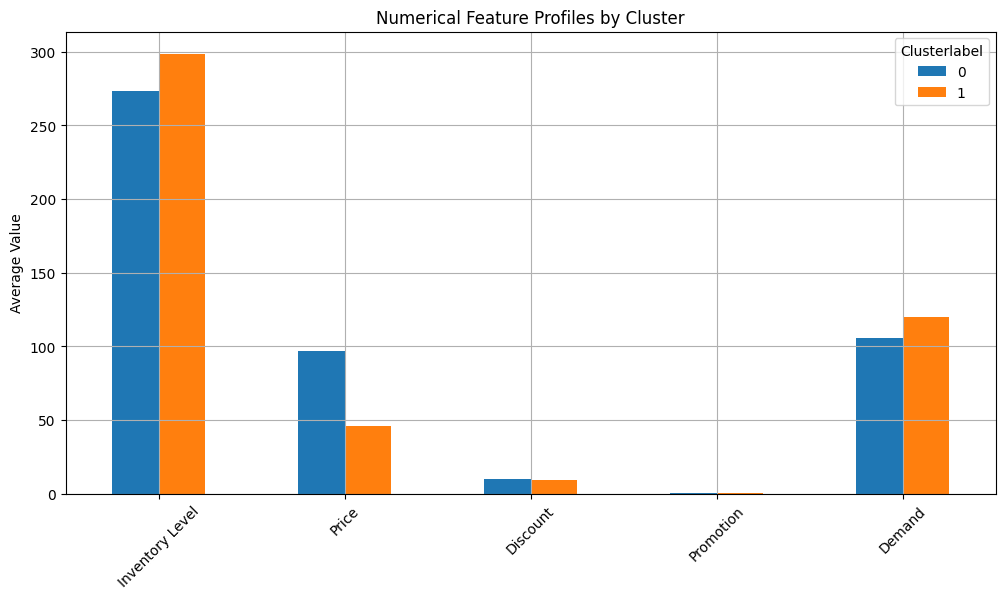

In [349]:
# We plot the different mean values of the numerical colunmns to compare them 
cluster_profiles.T.plot(kind='bar', figsize=(12,6))
plt.title("Numerical Feature Profiles by Cluster")
plt.ylabel("Average Value")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()



Category Proportions by Cluster for 'Category':


Category,Clothing,Electronics,Furniture,Groceries,Toys
Clusterlabel,,,,,
0,0.35,0.26,0.39,0.00,0.00
1,0.00,0.00,0.00,0.74,0.26


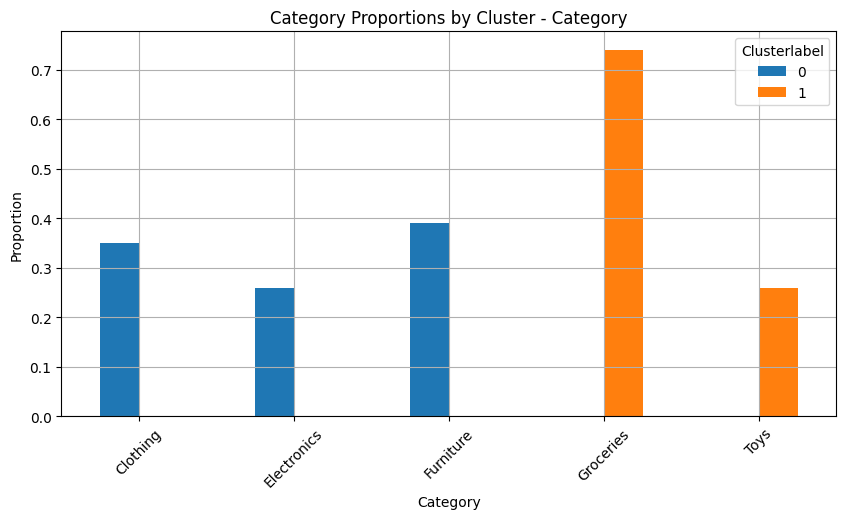


Category Proportions by Cluster for 'Region':


Region,East,North,South,West
Clusterlabel,,,,
0,0.17,0.36,0.19,0.28
1,0.22,0.45,0.20,0.13


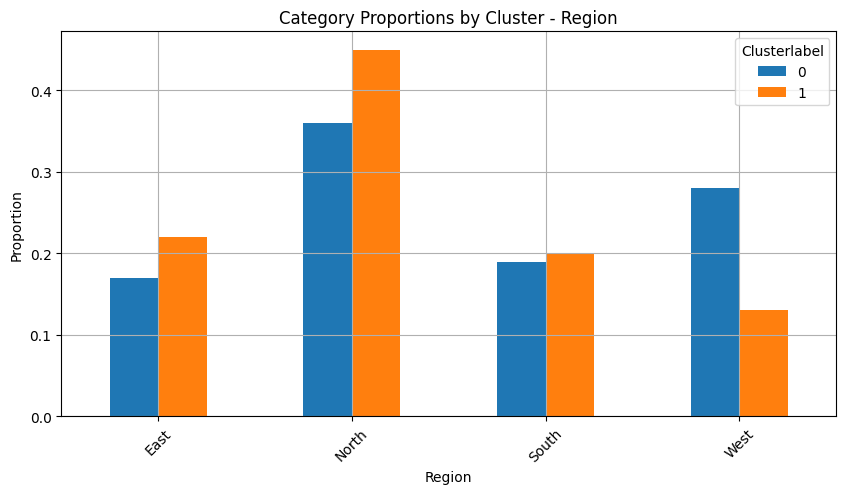


Category Proportions by Cluster for 'Weather Condition':


Weather Condition,Cloudy,Snowy,Sunny
Clusterlabel,,,
0,0.40,0.35,0.25
1,0.37,0.35,0.28


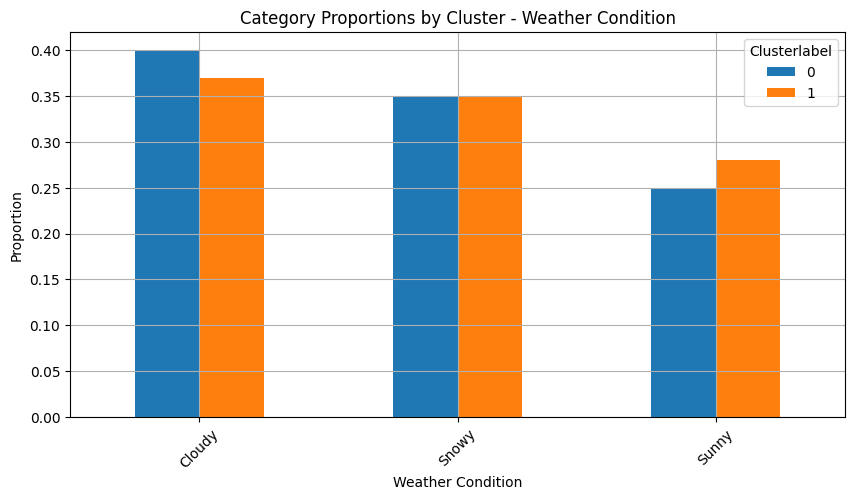


Category Proportions by Cluster for 'Weekday':


Weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Clusterlabel,,,,,,,
0,0.12,0.17,0.17,0.17,0.12,0.13,0.12
1,0.12,0.17,0.17,0.17,0.12,0.13,0.12


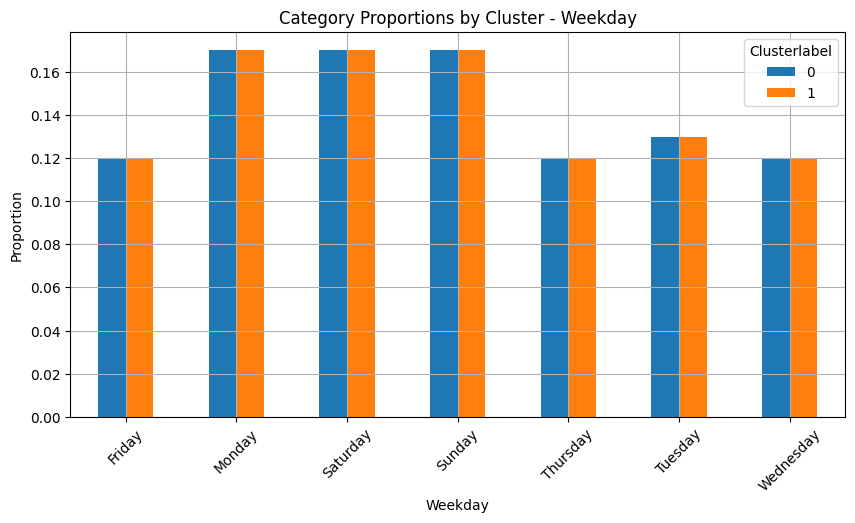

In [350]:
# Select non-numeric (categorical) columns, excluding 'Product_UID'
df_orig_cat = df_orig.select_dtypes(exclude=[np.number]).drop(columns=["Product_UID"])

# Combine with cluster labels
df_cat_with_clusters = df_orig_cat.copy()
df_cat_with_clusters["Clusterlabel"] = df_orig["Clusterlabel"]

# Calculate proportions of each category per cluster
cat_profiles = {}
for col in df_cat_with_clusters.columns:
    if col != "Clusterlabel":
        proportions = df_cat_with_clusters.groupby("Clusterlabel")[col].value_counts(normalize=True).unstack().fillna(0)
        cat_profiles[col] = proportions.round(2)

# Display results
for col, df in cat_profiles.items():
    print(f"\nCategory Proportions by Cluster for '{col}':")
    display(df)

    # Plotting
    df.T.plot(kind='bar', figsize=(10, 5))
    plt.title(f"Category Proportions by Cluster - {col}")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
